<a href="https://colab.research.google.com/github/dntwaritag/Data-Preprocessing-Peer-16/blob/main/Data_Preprocessing_Peer_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part 1: Data Augmentation on CSV Files**

**1. Load the Dataset**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor



In [ ]:
# Mount Google Drive (if using Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load transactions data
transactions = pd.read_csv('/content/drive/MyDrive/Mathematics for Machine Learning/Datasets/customer_transactions.csv')
#/content/drive/MyDrive/Mathematics for Machine Learning/Datasets/id_mapping.csv
transactions.head()


,customer_id_legacy,transaction_id,purchase_amount,purchase_date,product_category,customer_rating
0,151,1001,408,2024-01-01,Sports,2.3
1,192,1002,332,2024-01-02,Electronics,4.2
2,114,1003,442,2024-01-03,Electronics,2.1
3,171,1004,256,2024-01-04,Clothing,2.8
4,160,1005,64,2024-01-05,Clothing,1.3


**2. Handle Missing Values**

In [ ]:
# Check missing values
print(transactions.isnull().sum())

# Impute missing customer_rating using Random Forest
# Separate features and target
rating_data = transactions.dropna(subset=['customer_rating'])
missing_ratings = transactions[transactions['customer_rating'].isnull()]

# Define features (purchase_amount, product_category encoded)
features = pd.get_dummies(rating_data[['purchase_amount', 'product_category']])
target = rating_data['customer_rating']

# Train model
model = RandomForestRegressor()
model.fit(features, target)

# Predict missing ratings
missing_features = pd.get_dummies(missing_ratings[['purchase_amount', 'product_category']])
imputed_ratings = model.predict(missing_features)
transactions.loc[transactions['customer_rating'].isnull(), 'customer_rating'] = imputed_ratings

customer_id_legacy     0
transaction_id         0
purchase_amount        0
purchase_date          0
product_category       0
customer_rating       10
dtype: int64


**3. Data Augmentation**

In [ ]:
# Add random noise to purchase_amount (5% noise)
transactions['purchase_amount'] = transactions['purchase_amount'] * (1 + np.random.normal(0, 0.05, len(transactions)))


In [ ]:
# Log transformation for skewed purchase_amount
if transactions['purchase_amount'].skew() > 1:
    transactions['log_purchase_amount'] = np.log1p(transactions['purchase_amount'])

In [ ]:
# Generate synthetic transactions by resampling
synthetic_samples = transactions.sample(n=100, replace=True, random_state=42)
synthetic_samples['purchase_amount'] = synthetic_samples['purchase_amount'] * (1 + np.random.normal(0, 0.1, 100))
augmented_transactions = pd.concat([transactions, synthetic_samples], ignore_index=True)

**4. Export Augmented Data**

In [ ]:
augmented_transactions.to_csv('customer_transactions_augmented.csv', index=False)

# **Part 2: Merging Datasets with Transitive Properties**

**1. Load Mapping and Social Profiles**

In [ ]:
id_mapping = pd.read_csv('/content/drive/MyDrive/Mathematics for Machine Learning/Datasets/id_mapping.csv')
social_profiles = pd.read_csv('/content/drive/MyDrive/Mathematics for Machine Learning/Datasets/customer_social_profiles.csv')
augmented_transactions = pd.read_csv('/content/customer_transactions_augmented.csv')

# Merge transactions with ID mapping
merged = pd.merge(augmented_transactions, id_mapping, on='customer_id_legacy', how='left')

# Handle multiple mappings by taking the first customer_id_new
merged = merged.drop_duplicates(subset=['customer_id_legacy', 'transaction_id'], keep='first')

# Merge with social profiles
final_data = pd.merge(merged, social_profiles, on='customer_id_new', how='left')

**2. Feature Engineering**

In [ ]:
# Customer Engagement Score (weighted average)
final_data['engagement_score'] = 0.6 * final_data['engagement_score'] + 0.4 * final_data['customer_rating']

# Time-based aggregation (monthly purchases)
final_data['purchase_date'] = pd.to_datetime(final_data['purchase_date'])
final_data['month'] = final_data['purchase_date'].dt.month
monthly_spending = final_data.groupby(['customer_id_new', 'month'])['purchase_amount'].mean().reset_index(name='monthly_avg_spending')
final_data = pd.merge(final_data, monthly_spending, on=['customer_id_new', 'month'], how='left')

# TF-IDF for review_sentiment (convert to numerical)
from sklearn.feature_extraction.text import TfidfVectorizer

# Fill NaN values in 'review_sentiment' with an empty string
final_data['review_sentiment'] = final_data['review_sentiment'].fillna('')

tfidf = TfidfVectorizer(max_features=10)
sentiment_tfidf = tfidf.fit_transform(final_data['review_sentiment'])
sentiment_df = pd.DataFrame(sentiment_tfidf.toarray(), columns=tfidf.get_feature_names_out())
final_data = pd.concat([final_data, sentiment_df], axis=1)

**3. Export Merged Data**

In [ ]:
final_data.to_csv('final_customer_data_group16.csv', index=False)

# **Part 3: Data Consistency and Quality Checks**

**1. Data Integrity Checks**

In [ ]:
# Check duplicates
print(final_data.duplicated().sum())

# Validate categorical mappings
print(final_data['product_category'].unique())

# Ensure all transactions have valid social profiles
print(final_data[final_data['customer_id_new'].isnull()])

5
['Sports' 'Electronics' 'Clothing' 'Groceries' 'Books']
     customer_id_legacy  transaction_id  purchase_amount purchase_date  \
3                   171            1004       266.557868    2024-01-04   
4                   160            1005        62.924617    2024-01-05   
18                  123            1013       275.860277    2024-01-13   
19                  102            1014       100.040180    2024-01-14   
53                  148            1030       133.577086    2024-01-30   
71                  154            1043       345.410433    2024-02-12   
74                  102            1045       403.706091    2024-02-14   
78                  172            1049       239.502023    2024-02-18   
82                  117            1051       417.732384    2024-02-20   
87                  108            1056       167.690031    2024-02-25   
102                 143            1064       238.149972    2024-03-04   
103                 107            1065       262.1938

**2. Statistical Summarization**

       customer_id_legacy  transaction_id  purchase_amount  \
count          233.000000      233.000000       233.000000   
mean           148.523605     1073.639485       282.846210   
min            100.000000     1001.000000        52.237912   
25%            121.000000     1032.000000       191.121226   
50%            148.000000     1073.000000       271.297533   
75%            180.000000     1112.000000       395.321388   
max            199.000000     1150.000000       515.731785   
std             31.589372       43.813265       117.245958   

                       purchase_date  customer_rating  engagement_score  \
count                            233       233.000000        180.000000   
mean   2024-03-13 15:20:51.502146048         3.026936         47.377476   
min              2024-01-01 00:00:00         1.000000         30.480000   
25%              2024-02-01 00:00:00         2.100000         42.262260   
50%              2024-03-13 00:00:00         3.064000         47.6

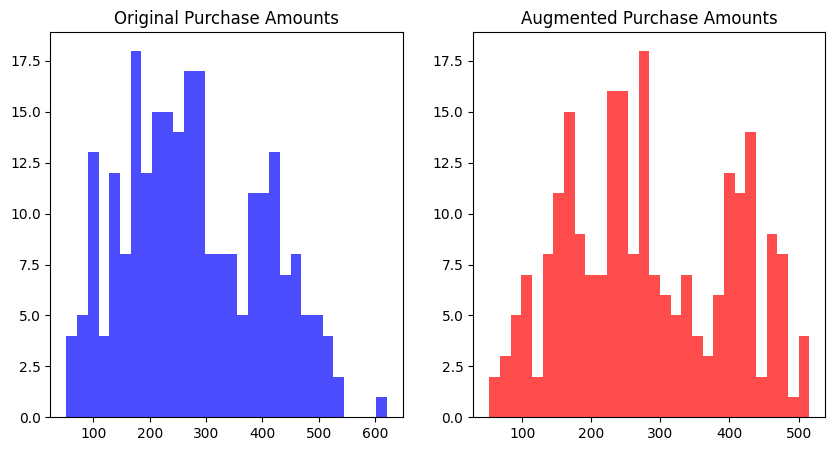

In [ ]:
# Generate describe report
print(final_data.describe())

# Visualize distributions
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(augmented_transactions['purchase_amount'], bins=30, color='blue', alpha=0.7)
plt.title('Original Purchase Amounts')
plt.subplot(1, 2, 2)
plt.hist(final_data['purchase_amount'], bins=30, color='red', alpha=0.7)
plt.title('Augmented Purchase Amounts')
plt.show()

**3. Feature Selection**

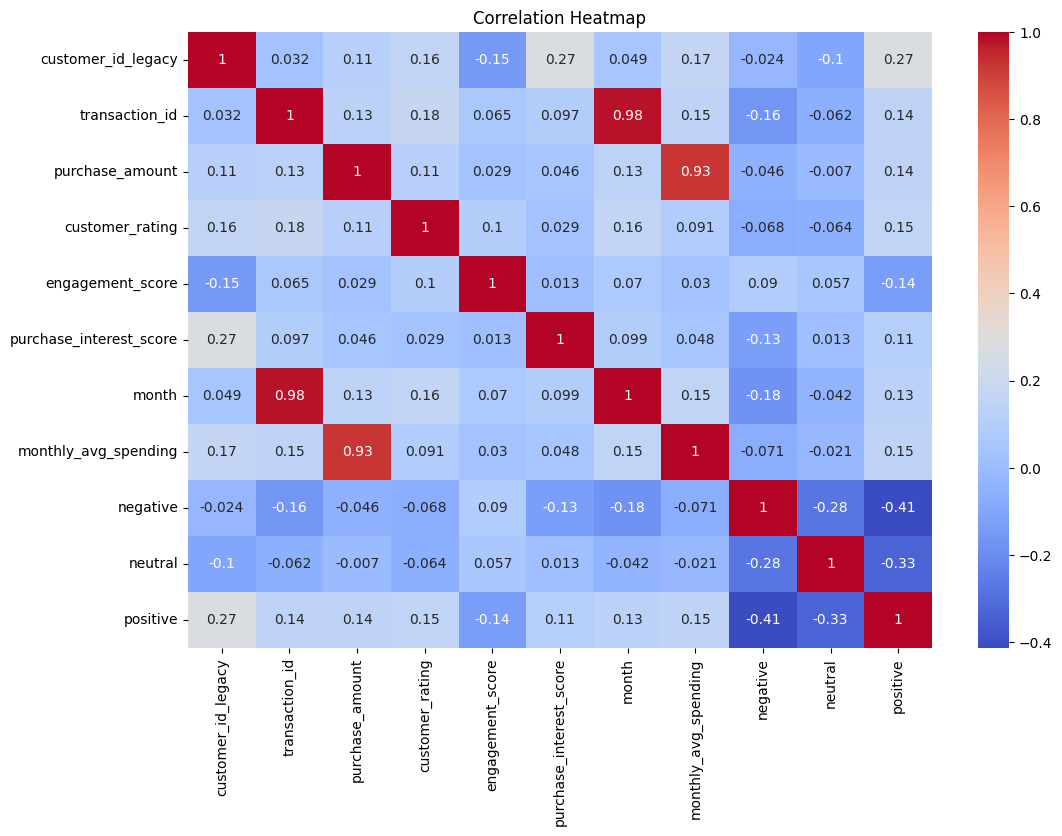

In [ ]:
# Correlation heatmap
import seaborn as sns
corr_matrix = final_data.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')

# Select top 10 features using Random Forest importance
from sklearn.ensemble import RandomForestRegressor
X = final_data.select_dtypes(include=[np.number]).dropna(axis=1)
y = X.pop('purchase_amount')
model = RandomForestRegressor()
model.fit(X, y)
importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
top_features = importance.head(10).index.tolist()

**4. Export Final Dataset**

In [ ]:
final_data[top_features + ['purchase_amount']].to_csv('final_dataset_ready_group16.csv', index=False)

## **Summary of Key Steps**

1. **Data Augmentation:** Added synthetic transactions, imputed missing ratings, and applied log transformation.

2. **Merging:** Linked legacy and new customer IDs, resolved conflicts, and engineered features like engagement scores.

3. **Quality Checks:** Ensured no duplicates, validated categorical data, and performed statistical analysis.

## **Challenges**

- **Multiple Mappings:** Resolved by keeping the first occurrence.

- **Missing Ratings:** Used Random Forest for accurate imputation.

- **Feature Engineering:** Combined domain knowledge to create meaningful scores.

## **Bonus Challenge Predict Cusstomer Spending**

In [ ]:
# Importing necessary Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib

In [ ]:
# Load the preprocessed dataset
final_data = pd.read_csv('/content/final_dataset_ready_group16.csv')
final_data.head()

,transaction_id,customer_id_legacy,customer_rating,positive,month,negative,neutral,purchase_amount
0,1001,151,2.3,0.0,1,1.0,0.0,431.606106
1,1002,192,4.2,1.0,1,0.0,0.0,327.077199
2,1003,114,2.1,0.0,1,0.0,0.0,422.541366
3,1004,171,2.8,0.0,1,0.0,0.0,266.557868
4,1005,160,1.3,0.0,1,0.0,0.0,62.924617


**Data Preparation**

In [ ]:
# Separate features and target
X = final_data.drop('purchase_amount', axis=1)
y = final_data['purchase_amount']

# Handle remaining missing values using median imputation
X = X.fillna(X.median())

# Split data into training and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Model Training**

In [ ]:
# Initialize and train Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    random_state=42
)
rf_model.fit(X_train, y_train)

# Initialize and train XGBoost model
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

**Model Evaluation**

In [ ]:
def evaluate_model(model, X_test, y_test):
    """Evaluate model performance and return metrics"""
    predictions = model.predict(X_test)

    return {
        'MAE': mean_absolute_error(y_test, predictions),
        'MSE': mean_squared_error(y_test, predictions),
        'RMSE': np.sqrt(mean_squared_error(y_test, predictions)),
        'R2': r2_score(y_test, predictions)
    }

# Evaluate both models
rf_metrics = evaluate_model(rf_model, X_test, y_test)
xgb_metrics = evaluate_model(xgb_model, X_test, y_test)

print("Random Forest Performance:")
print(pd.DataFrame([rf_metrics]))
print("\nXGBoost Performance:")
print(pd.DataFrame([xgb_metrics]))

Random Forest Performance:
         MAE          MSE       RMSE        R2
0  75.658086  8983.924008  94.783564  0.291145

XGBoost Performance:
         MAE          MSE       RMSE        R2
0  67.187651  8832.238889  93.979992  0.303113


**Feature Importance Visualisation**

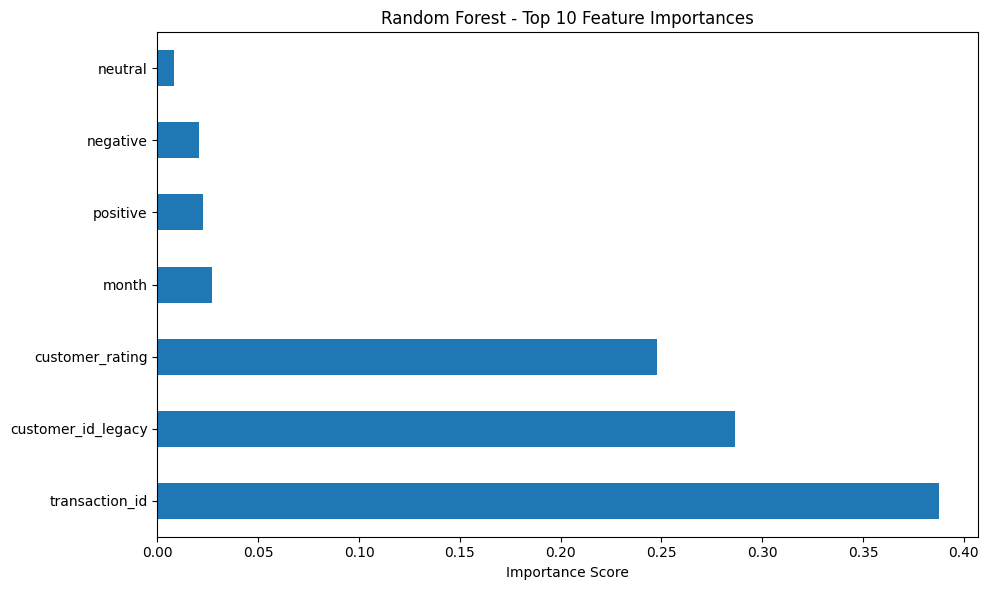

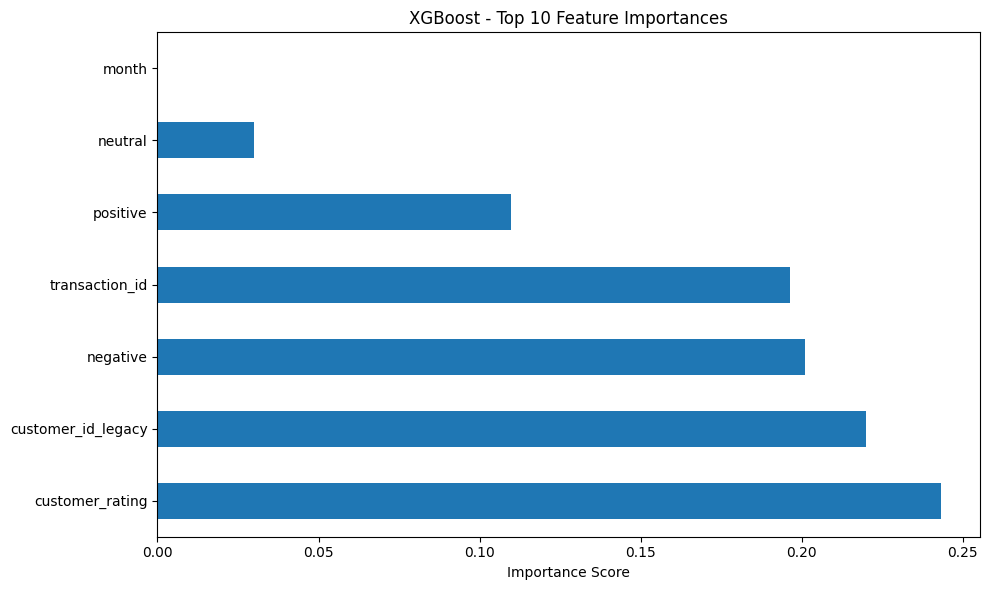

In [ ]:
# Plot feature importances for Random Forest
rf_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 6))
rf_importances.nlargest(10).plot(kind='barh')
plt.title('Random Forest - Top 10 Feature Importances')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.savefig('rf_feature_importance.png')
plt.show()

# Plot feature importances for XGBoost
xgb_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 6))
xgb_importances.nlargest(10).plot(kind='barh')
plt.title('XGBoost - Top 10 Feature Importances')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.savefig('xgb_feature_importance.png')
plt.show()

**Prediction Visualisation**

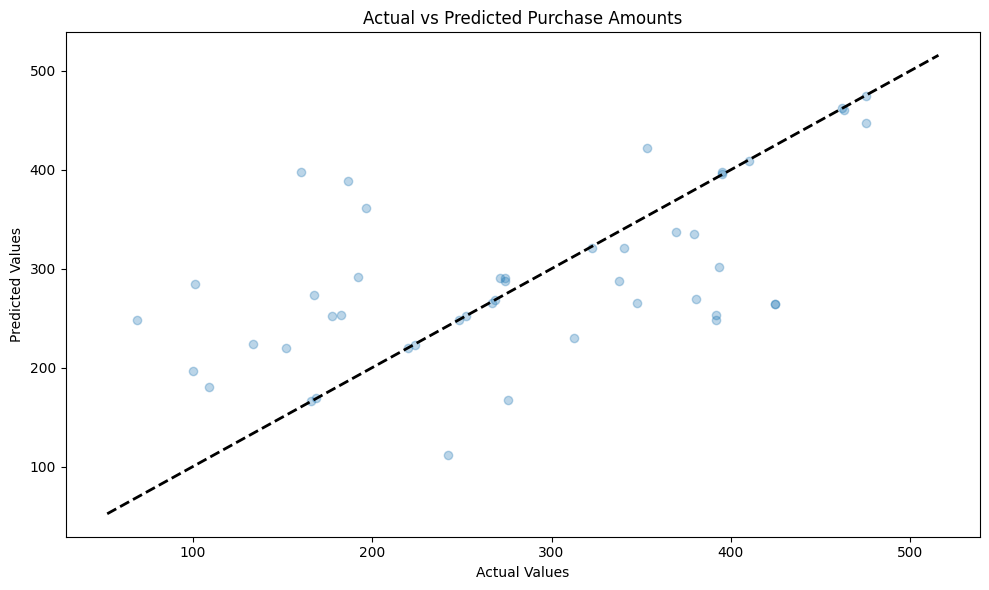

In [ ]:
# Plot actual vs predicted values for best model
best_model = xgb_model if xgb_metrics['R2'] > rf_metrics['R2'] else rf_model
predictions = best_model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Purchase Amounts')
plt.tight_layout()
plt.savefig('actual_vs_predicted.png')
plt.show()

**Model Persistence**

In [ ]:
# Save the best performing model
joblib.dump(best_model, 'best_spending_predictor.pkl')

['best_spending_predictor.pkl']

**Inference Example**

In [ ]:
# Example prediction using new data
sample_data = X_test.iloc[0:1]
prediction = best_model.predict(sample_data)

print(f"\nExample Prediction:")
print(f"Input Features:\n{sample_data}")
print(f"Predicted Purchase Amount: ${prediction[0]:.2f}")
print(f"Actual Purchase Amount: ${y_test.iloc[0]:.2f}")


Example Prediction:
Input Features:
    transaction_id  customer_id_legacy  customer_rating  positive  month  \
84            1053                 188              3.3       1.0      2   

    negative  neutral  
84       0.0      0.0  
Predicted Purchase Amount: $320.53
Actual Purchase Amount: $340.53
